In [39]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/hin/Documents/St_Andrews/dense_basis')
import dense_basis as db

from george import kernels
import george
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70., Om0=0.3)

from scipy.optimize import minimize

# Background
The aim of this experiment is to take Yirui's "true" SFH, bin it under non parametric SFH schemes to simulate a posterior sample from fitting the galaxy's spectrum, then test which scheme of NP SFH best recreates the SFH of a PSB best with few enough bins. Of course actual fitting from the spectrum will be much more complicated and I am fitting the true SFH here directly, but this should give us some idea of how the different schemes behave given this one SFH of a PSB.

First copy-pasted functions from dense_basis's gp-sfh part

In [425]:
def nll(p, gp, y):
    gp.set_parameter_vector(p)
    return -gp.log_likelihood(y)

def grad_nll(p, gp, y):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(y)

def gp_interpolator(x,y,res = 1000, Nparam = 3, decouple_sfr = False):

    yerr = np.zeros_like(y)
    yerr[2:(2+Nparam)] = 0.001/np.sqrt(Nparam)
    if len(yerr) > 26:
        yerr[2:(2+Nparam)] = 0.1/np.sqrt(Nparam)
    yerr[(2+Nparam):] = 0.1
    #kernel = np.var(y) * kernels.ExpSquaredKernel(np.median(y))
    #kernel = np.var(y) * kernels.LinearKernel(np.median(y),order=1)
    kernel = np.var(y) * kernels.Matern32Kernel(np.median(y)) #+ k2
    #kernel = np.var(y) * (kernels.Matern32Kernel(np.median(y)) + kernels.LinearKernel(np.median(y), order=2))
    gp = george.GP(kernel, solver=george.HODLRSolver)

    #print(xax.shape, yerr.shape)
    gp.compute(x.ravel(), yerr.ravel())
    
    # optimize kernel parameters
    p0 = gp.get_parameter_vector()
    results = minimize(nll, p0, jac=grad_nll, method="L-BFGS-B", args = (gp, y))
    print(results)
    gp.set_parameter_vector(results.x)

    x_pred = np.linspace(np.amin(x), np.amax(x), res)
    y_pred, pred_var = gp.predict(y.ravel(), x_pred, return_var=True)

    return x_pred, y_pred

def tuple_to_sfh(sfh_tuple, zval, interpolator = 'gp_george', decouple_sfr = False, decouple_sfr_time = 10, sfr_tolerance = 0.05, vb = False,cosmo = cosmo):
    # generate an SFH from an input tuple (Mass, SFR, {tx}) at a specified redshift


    Nparam = int(sfh_tuple[2])
    mass_quantiles = np.linspace(0,1,Nparam+2)
    time_quantiles = np.zeros_like(mass_quantiles)
    time_quantiles[-1] = 1
    time_quantiles[1:-1] = sfh_tuple[3:]
    
    if vb == True:
        print('pre-adjustment:',time_quantiles, mass_quantiles)

    # now add SFR constraints

    # SFR smoothly increasing from 0 at the big bang
    mass_quantiles = np.insert(mass_quantiles,1,[0.00])
    time_quantiles = np.insert(time_quantiles,1,[0.01])

    # SFR constrained to SFR_inst at the time of observation
    #SFH_constraint_percentiles = np.array([0.96,0.97,0.98,0.99])
    SFH_constraint_percentiles = np.array([0.97, 0.98, 0.99])
    for const_vals in SFH_constraint_percentiles:

        delta_mstar = 10**(sfh_tuple[0]) *(1-const_vals)
        delta_t = 1 - delta_mstar/(10**sfh_tuple[1])/(cosmo.age(zval).value*1e9)
        if vb == True:
            print(delta_t,time_quantiles[-2])

        if (delta_t > time_quantiles[-2]) & (delta_t > 0.9):
            if vb == True:
                print('if', const_vals)
            mass_quantiles = np.insert(mass_quantiles, -1, [const_vals], )
            time_quantiles = np.insert(time_quantiles, -1, [delta_t],)
        else:
            if vb == True:
                print('else', const_vals)
            if const_vals > time_quantiles[-2]:
                delta_m = 1 - ((cosmo.age(zval).value*1e9)*(1-const_vals)*(10**sfh_tuple[1]))/(10**sfh_tuple[0])
                time_quantiles = np.insert(time_quantiles, -1, [const_vals])
                mass_quantiles=  np.insert(mass_quantiles, -1, [delta_m])
    
    if vb == True:
        print('post-adjustment:',time_quantiles, mass_quantiles)
    
    if interpolator == 'gp_george':
        time_arr_interp, mass_arr_interp = gp_interpolator(time_quantiles, mass_quantiles, Nparam = int(Nparam), decouple_sfr = decouple_sfr)
    elif interpolator == 'gp_sklearn':
        time_arr_interp, mass_arr_interp = gp_sklearn_interpolator(time_quantiles, mass_quantiles)
    elif interpolator == 'linear':
        time_arr_interp, mass_arr_interp = linear_interpolator(time_quantiles, mass_quantiles)
    elif interpolator == 'pchip':
        time_arr_interp, mass_arr_interp = Pchip_interpolator(time_quantiles, mass_quantiles)
    else:
        raise Exception('specified interpolator does not exist: {}. \n use one of the following: gp_george, gp_sklearn, linear, and pchip '.format(interpolator))

    sfh_scale = 10**(sfh_tuple[0])/(cosmo.age(zval).value*1e9/1000)
    sfh = np.diff(mass_arr_interp)*sfh_scale
    sfh[sfh<0] = 0
    sfh = np.insert(sfh,0,[0])
    
    sfr_decouple_time_index = np.argmin(np.abs(time_arr_interp*cosmo.age(zval).value - decouple_sfr_time/1e3))
    if sfr_decouple_time_index == 0:
        sfr_decouple_time_index = 2
    mass_lastbins = np.trapz(x=time_arr_interp[-sfr_decouple_time_index:]*1e9*(cosmo.age(zval).value), y=sfh[-sfr_decouple_time_index:])
    mass_remaining = 10**(sfh_tuple[0]) - mass_lastbins
    if mass_remaining < 0:
        mass_remaining = 0
        print('input SFR, M* combination is not physically consistent (log M*: %.2f, log SFR: %.2f.)' %(sfh_tuple[0],sfh_tuple[1]))
    mass_initbins = np.trapz(x=time_arr_interp[0:(1000-sfr_decouple_time_index)]*1e9*(cosmo.age(zval).value), y=sfh[0:(1000-sfr_decouple_time_index)])
    sfh[0:(1000-sfr_decouple_time_index)] = sfh[0:(1000-sfr_decouple_time_index)] * mass_remaining / mass_initbins
    
    if (np.abs(np.log10(sfh[-1]) - sfh_tuple[1]) > sfr_tolerance) or (decouple_sfr == True):
        sfh[-sfr_decouple_time_index:] = 10**sfh_tuple[1]
    
#     if decouple_sfr == True:
#         sfr_decouple_time_index = np.argmin(np.abs(time_arr_interp*cosmo.age(zval).value - decouple_sfr_time/1e3))
#         sfh[-sfr_decouple_time_index:] = 10**sfh_tuple[1]

    timeax = time_arr_interp * cosmo.age(zval).value

    if vb == True:
        print('time and mass quantiles:')
        print(time_quantiles, mass_quantiles)
        plt.plot(time_quantiles, mass_quantiles,'--o')
        plt.plot(time_arr_interp, mass_arr_interp)
        plt.axis([0,1,0,1])
        #plt.axis([0.9,1.05,0.9,1.05])
        plt.show()

        print('instantaneous SFR: %.1f' %sfh[-1])
        plt.plot(np.amax(time_arr_interp) - time_arr_interp, sfh)
        #plt.xscale('log')
        plt.show()

    return sfh, timeax

Loading in the true SFH and calculating important variables

In [478]:
plt.rcParams.update({'font.size': 14})

sim_data = np.loadtxt('../Yirui_test_cube/snap119/2xSc_07_EC_BH_vw1e4_ReposNoRFBNoRP_snap119_SFH_at_diff_radius.txt')
age_at_z = cosmo.age(0.04).value
model_lb_time = sim_data[:,0]
model_ages = age_at_z - model_lb_time
mask = model_ages > 0
model_ages = model_ages[mask][::-1]
model_sfh = sim_data[:,2][mask][::-1]
model_lb_time = model_lb_time[mask][::-1]
model_Mstar = np.trapz(y=model_sfh, x=model_ages)*10**9

# Iyer2019's method of binning
Binning the true SFH using iyer's method (equal mass in each bin with adaptive bin boundaries) and calculate the resulting tx

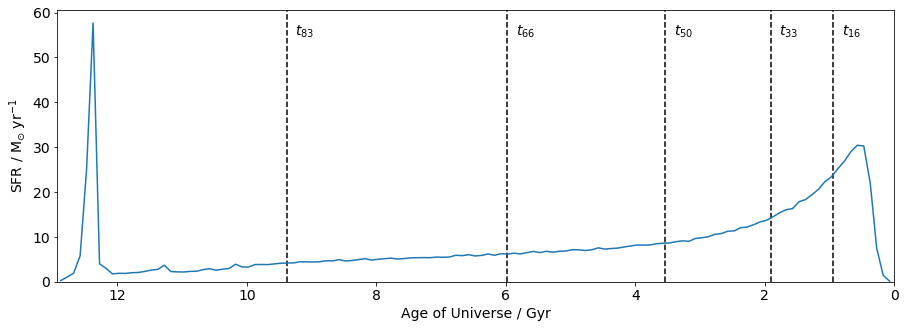

In [570]:
def bin_iyer(Nbins):
    total_mass = np.trapz(y=model_sfh, x=model_ages)
    c_mass = []
    for i,sfh in enumerate(model_sfh):
        c_mass.append(np.trapz(y=model_sfh[:i+1], x=model_ages[:i+1])/total_mass)
    mass_percentiles = np.arange(1,Nbins)*1/Nbins
    tx = np.interp(mass_percentiles, c_mass, model_ages/age_at_z)
    return np.array(tx)

Nbins = 6
tx = bin_iyer(Nbins)

fig, ax = plt.subplots(figsize=[15,5])
ax.plot(model_ages, model_sfh)
ax.set_xlim([age_at_z,0])
ax.set_xlabel('Age of Universe / Gyr')
ax.set_ylabel(r'SFR / $\rm{M_{\odot}}\; \rm{yr}^{-1}$')
ylims = ax.get_ylim()
ax.vlines(tx*age_at_z, 0, ylims[1], color='k', ls='--')
for i,txi in enumerate(tx):
    ax.annotate('$t_{'+str(int((i+1)*100/Nbins))+'}$', [(txi-0.01)*age_at_z, 0.95*max(model_sfh)])
ax.set_ylim([0,ylims[1]])
plt.show()

Fitting the calculated tx values with GP to attempt to recreate the true SFH

      fun: -6.271727943090349
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.60196580e-07,  1.21272822e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 12
      nit: 11
     njev: 12
   status: 0
  success: True
        x: array([-1.00623003, -1.48282861])


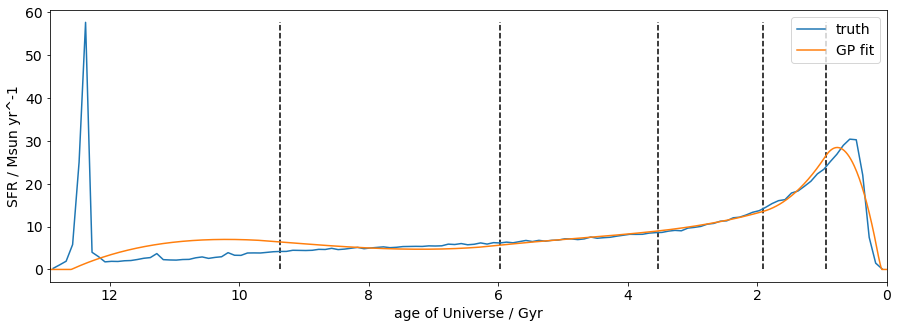

In [571]:
def db_fit(Nbins, tx):
    iyer_param = np.hstack([np.log10(model_Mstar), np.log10(model_sfh[-1]), Nbins-1, tx])
    iyer_sfh, iyer_ages = tuple_to_sfh(iyer_param, 0.04, vb=False)
    return iyer_ages, iyer_sfh

iyer_ages, iyer_sfh = db_fit(Nbins, tx)
fig, ax = plt.subplots(figsize=[15,5])
ax.plot(model_ages, model_sfh, label='truth')
ax.vlines(tx*age_at_z, min(model_sfh), max(model_sfh), color='k', ls='--')
ax.plot(iyer_ages, iyer_sfh, label='GP fit')
ax.set_xlim([age_at_z,0])
ax.set_xlabel('age of Universe / Gyr')
ax.set_ylabel('SFR / Msun yr^-1')
ax.legend()
plt.show()

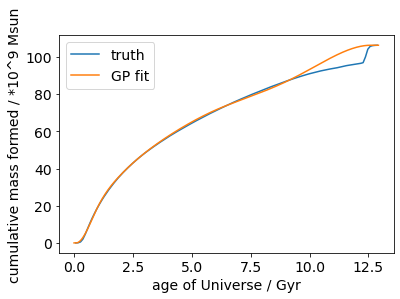

In [572]:
#cumulative mass formed vs age
Mstar_total_model = np.trapz(model_sfh, x=model_ages)
c_model_sfh = np.zeros(len(model_sfh))
for i,sfh in enumerate(model_sfh):
    c_model_sfh[i] = np.trapz(model_sfh[:i+1],x=model_ages[:i+1])#/Mstar_total_model

Mstar_total_iyer = np.trapz(iyer_sfh, x=iyer_ages)
c_iyer_sfh = np.zeros(len(iyer_ages))
for i,sfh in enumerate(iyer_sfh):
    c_iyer_sfh[i] = np.trapz(iyer_sfh[:i+1],x=iyer_ages[:i+1])#/Mstar_total_iyer

plt.plot(model_ages, c_model_sfh, label='truth')
plt.plot(iyer_ages, c_iyer_sfh, label='GP fit')
plt.xlabel('age of Universe / Gyr')
plt.ylabel('cumulative mass formed / *10^9 Msun')
plt.legend()
plt.show()

What if for higher number of bins?

      fun: -6.271727943090349
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.60196580e-07,  1.21272822e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 12
      nit: 11
     njev: 12
   status: 0
  success: True
        x: array([-1.00623003, -1.48282861])
      fun: -15.110769409449889
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-4.58764350e-06,  1.07676851e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 11
      nit: 10
     njev: 11
   status: 0
  success: True
        x: array([-0.95934066, -1.10814435])
      fun: -26.94353018711666
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.3438897e-05, -2.6473946e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 10
      nit: 9
     njev: 10
   status: 0
  success: True
        x: array([-0.96289706, -0.8795562 ])
      fun: -47.7434379703654
 hess_inv: <2x2 Lbfgs

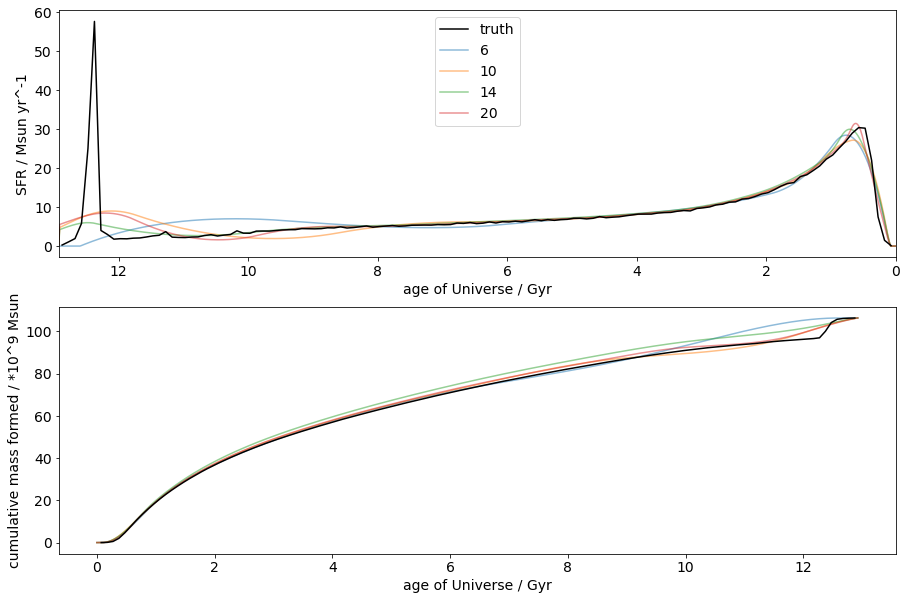

In [481]:
fig, ax = plt.subplots(2,1,figsize=[15,10])
ax[0].plot(model_ages, model_sfh, label='truth', zorder=4, color='k')
ax[1].plot(model_ages, c_model_sfh, label='truth', zorder=4, color='k')
for Nbins in [6,10,14,20]:
    tx = bin_iyer(Nbins)
    iyer_ages, iyer_sfh = db_fit(Nbins, tx)
    ax[0].plot(iyer_ages, iyer_sfh, label=Nbins, alpha=0.5)
    
    c_iyer_sfh = np.zeros(len(iyer_ages))
    for i,sfh in enumerate(iyer_sfh):
        c_iyer_sfh[i] = np.trapz(iyer_sfh[:i+1],x=iyer_ages[:i+1])
    ax[1].plot(iyer_ages, c_iyer_sfh, label=Nbins, alpha=0.5)
ax[0].set_xlim([age_at_z,0])
ax[0].set_xlabel('age of Universe / Gyr')
ax[0].set_ylabel('SFR / Msun yr^-1')
ax[0].legend()
ax[1].set_xlabel('age of Universe / Gyr')
ax[1].set_ylabel('cumulative mass formed / *10^9 Msun')
plt.show()

Comments:

Ok, even with just 6 bins with Iyer's method is able to capture the curve in early-formation quite well, but the starburst can never be recreated, not even with 20 bins.

# Uniform bin width in log time
Alternative binning scheme proposed by Vivienne: to definie bin boundaries as uniform width in log lookback time, and fit for the mass formed in each bin

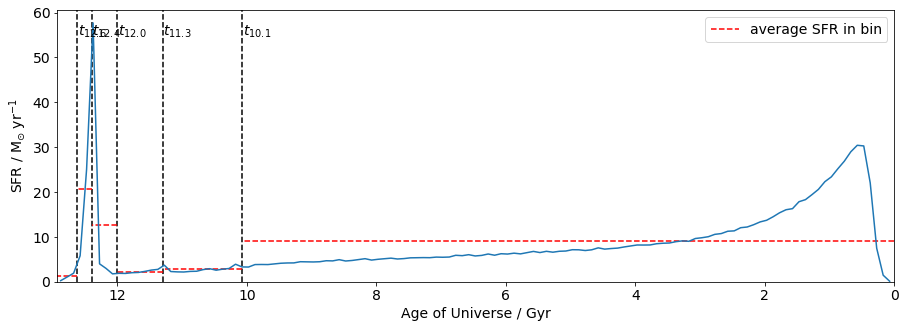

In [573]:
def bin_logtime(Nbins, interp=True, begin_time=3*10**8, end_time=None):
    # begin_time and end_time are the two extremes at which the bin boundaries are linspaced between
    # Note that they are in lookback time instead of age
    if end_time == None:
        end_time = age_at_z*10**9
    logtime_per_bin = (np.log10(end_time)-np.log10(begin_time))/(Nbins-1)
    tx = age_at_z - 10**(np.arange(Nbins-1)*logtime_per_bin + np.log10(begin_time) - 9)
    tx = tx[::-1]
    
    mass_so_far = [0]
    for txi in tx:
        if interp==True:
            sfh_at_txi = np.interp(txi, model_ages, model_sfh)
            insert_index = model_ages.searchsorted(txi)
            model_ages_ = np.insert(model_ages,insert_index,txi)
            model_sfh_ = np.insert(model_sfh,insert_index,sfh_at_txi)
            int_mass = np.trapz(y=model_sfh_[model_ages_<=txi], x=model_ages_[model_ages_<=txi]*10**9)
        else:
            int_mass = np.trapz(y=model_sfh[model_ages<=txi], x=model_ages[model_ages<=txi]*10**9)
        mass_so_far.append(int_mass)
    #mass_so_far.append(np.trapz(y=model_sfh, x=model_ages*10**9))
    mass_so_far = np.array(mass_so_far)
    mass_formed = mass_so_far[1:]-mass_so_far[:-1]
    t_mass_formed = np.trapz(y=model_sfh, x=model_ages*10**9)
    return tx/age_at_z, mass_formed/t_mass_formed

Nbins = 6
tx, f_mass_formed = bin_logtime(Nbins, interp=True, end_time=5*10**9)
tx_ = np.array([0,*tx, 1])*age_at_z
f_mass_formed_ = np.insert(f_mass_formed, len(f_mass_formed), 1-np.sum(f_mass_formed))
durations = abs(tx_[1:] - tx_[:-1])
sfrs = f_mass_formed_*np.trapz(y=model_sfh, x=model_ages*10**9)/durations/10**9

fig, ax = plt.subplots(figsize=[15,5])
ax.plot(model_ages, model_sfh)
ax.set_xlim([age_at_z,0])
ax.set_xlabel('Age of Universe / Gyr')
ax.set_ylabel(r'SFR / $\rm{M_{\odot}}\; \rm{yr}^{-1}$')
ylims = ax.get_ylim()
ax.vlines(tx*age_at_z, 0, ylims[1], color='k', ls='--')
ax.hlines(sfrs, tx_[:-1], tx_[1:], color='r', ls='--', label='average SFR in bin')

for i,txi in enumerate(tx):
    ax.annotate('$t_{'+str(np.round(txi*age_at_z,1))+'}$', [(txi*age_at_z-0.01), 0.95*max(model_sfh)])
ax.set_ylim([0,ylims[1]])
ax.legend()
plt.show()

A modification of dense_basis code to use GP to fit this new binning scheme

      fun: -11.659677747751378
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.41842719e-07,  1.52010479e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 11
      nit: 10
     njev: 11
   status: 0
  success: True
        x: array([-0.54691421, -0.63704599])


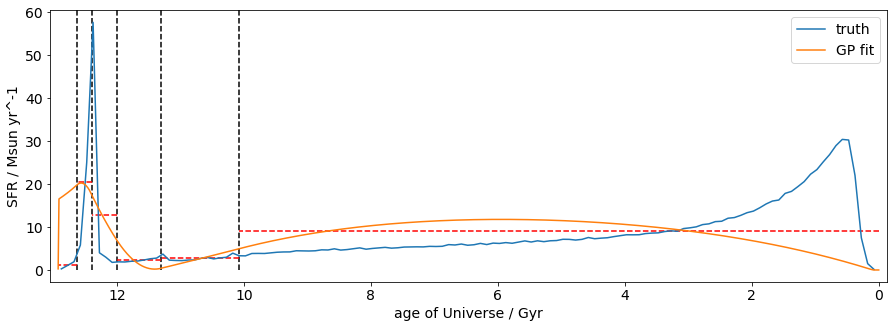

In [574]:
def fit_logtime(sfh_tuple, zval, interpolator = 'gp_george', decouple_sfr = False, 
                decouple_sfr_time = 10, sfr_tolerance = 0.05, vb = False,cosmo = cosmo):
    # sfh_tuple[0] = total mass formed in log10 form
    # sfh_tuple[1] = log10 SFR at time of observation
    # sfh_tuple[2] = list of time bin boundaries in fractions of the universe's current
    # sfh_tuple[3] = list of fraction mass formed at bin boundaries
    
    # generate an SFH from an input tuple at a specified redshift
    Nparam = int(sfh_tuple[2])
    input_tx = sfh_tuple[3:3+Nparam]
    input_mf = sfh_tuple[3+Nparam:3+2*Nparam]
    c_mass_formed = np.zeros(len(input_mf))
    for i,mi in enumerate(input_mf):
        c_mass_formed[i] = np.sum(input_mf[:i+1])
    mass_quantiles = np.array([0,*c_mass_formed,1])
    time_quantiles = np.zeros_like(mass_quantiles)
    time_quantiles[-1] = 1
    time_quantiles[1:-1] = input_tx
    
    if vb == True:
        print('pre-adjustment:',time_quantiles, mass_quantiles)
    
    # now add SFR constraints
    mass_quantiles = np.insert(mass_quantiles,1,[0.00])
    time_quantiles = np.insert(time_quantiles,1,[0.01])
    
    # SFR constrained to SFR_inst at the time of observation
    #SFH_constraint_percentiles = np.array([0.96,0.97,0.98,0.99])
    SFH_constraint_percentiles = np.array([0.97, 0.98, 0.99])
    for const_vals in SFH_constraint_percentiles:

        delta_mstar = 10**(sfh_tuple[0]) *(1-const_vals)
        delta_t = 1 - delta_mstar/(10**sfh_tuple[1])/(cosmo.age(zval).value*1e9)
        if vb == True:
            print(delta_t,time_quantiles[-2])

        if (delta_t > time_quantiles[-2]) & (delta_t > 0.9):
            if vb == True:
                print('if', const_vals)
            mass_quantiles = np.insert(mass_quantiles, -1, [const_vals], )
            time_quantiles = np.insert(time_quantiles, -1, [delta_t],)
        else:
            if vb == True:
                print('else', const_vals)
            if const_vals > time_quantiles[-2]:
                delta_m = 1 - ((cosmo.age(zval).value*1e9)*(1-const_vals)*(10**sfh_tuple[1]))/(10**sfh_tuple[0])
                time_quantiles = np.insert(time_quantiles, -1, [const_vals])
                mass_quantiles=  np.insert(mass_quantiles, -1, [delta_m])
    
    #debug stuff
    if vb == True:
        print('post-adjustment:',time_quantiles, mass_quantiles)
        plt.plot(model_ages, c_model_sfh)
        plt.plot(time_quantiles*age_at_z, mass_quantiles*np.trapz(y=model_sfh, x=model_ages))
        plt.show()
    
    if interpolator == 'gp_george':
        time_arr_interp, mass_arr_interp = gp_interpolator(time_quantiles, mass_quantiles, Nparam = int(Nparam), decouple_sfr = decouple_sfr)
    elif interpolator == 'gp_sklearn':
        time_arr_interp, mass_arr_interp = gp_sklearn_interpolator(time_quantiles, mass_quantiles)
    elif interpolator == 'linear':
        time_arr_interp, mass_arr_interp = linear_interpolator(time_quantiles, mass_quantiles)
    elif interpolator == 'pchip':
        time_arr_interp, mass_arr_interp = Pchip_interpolator(time_quantiles, mass_quantiles)
    else:
        raise Exception('specified interpolator does not exist: {}. \n use one of the following: gp_george, gp_sklearn, linear, and pchip '.format(interpolator))
        
    sfh_scale = 10**(sfh_tuple[0])/(cosmo.age(zval).value*1e9/1000)
    sfh = np.diff(mass_arr_interp)*sfh_scale
    sfh[sfh<0] = 0
    sfh = np.insert(sfh,0,[0])
    
    sfr_decouple_time_index = np.argmin(np.abs(time_arr_interp*cosmo.age(zval).value - decouple_sfr_time/1e3))
    if sfr_decouple_time_index == 0:
        sfr_decouple_time_index = 2
    mass_lastbins = np.trapz(x=time_arr_interp[-sfr_decouple_time_index:]*1e9*(cosmo.age(zval).value), y=sfh[-sfr_decouple_time_index:])
    mass_remaining = 10**(sfh_tuple[0]) - mass_lastbins
    if mass_remaining < 0:
        mass_remaining = 0
        print('input SFR, M* combination is not physically consistent (log M*: %.2f, log SFR: %.2f.)' %(sfh_tuple[0],sfh_tuple[1]))
    mass_initbins = np.trapz(x=time_arr_interp[0:(1000-sfr_decouple_time_index)]*1e9*(cosmo.age(zval).value), y=sfh[0:(1000-sfr_decouple_time_index)])
    sfh[0:(1000-sfr_decouple_time_index)] = sfh[0:(1000-sfr_decouple_time_index)] * mass_remaining / mass_initbins
    
    if (np.abs(np.log10(sfh[-1]) - sfh_tuple[1]) > sfr_tolerance) or (decouple_sfr == True):
        sfh[-sfr_decouple_time_index:] = 10**sfh_tuple[1]
    
#     if decouple_sfr == True:
#         sfr_decouple_time_index = np.argmin(np.abs(time_arr_interp*cosmo.age(zval).value - decouple_sfr_time/1e3))
#         sfh[-sfr_decouple_time_index:] = 10**sfh_tuple[1]

    timeax = time_arr_interp * cosmo.age(zval).value

    if vb == True:
        print('time and mass quantiles:')
        print(time_quantiles, mass_quantiles)
        plt.plot(time_quantiles, mass_quantiles,'--o')
        plt.plot(time_arr_interp, mass_arr_interp)
        plt.axis([0,1,0,1])
        #plt.axis([0.9,1.05,0.9,1.05])
        plt.show()

        print('instantaneous SFR: %.1f' %sfh[-1])
        plt.plot(np.amax(time_arr_interp) - time_arr_interp, sfh)
        #plt.xscale('log')
        plt.show()

    return sfh, timeax

def lt_fit(Nbins, tx, mf):
    lt_param = np.hstack([np.log10(model_Mstar), np.log10(model_sfh[-1]), Nbins-1, tx, mf])
    lt_sfh, lt_ages = fit_logtime(lt_param, 0.04, vb=False)
    return lt_ages, lt_sfh
    
lt_ages, lt_sfh = lt_fit(Nbins, tx, f_mass_formed)
fig, ax = plt.subplots(figsize=[15,5])
ax.plot(model_ages, model_sfh, label='truth')
ylims = ax.get_ylim()
ax.vlines(tx*age_at_z, 0, ylims[1], color='k', ls='--')
ax.hlines(sfrs, tx_[:-1], tx_[1:], color='r', ls='--')
ax.plot(lt_ages, lt_sfh, label='GP fit')
ax.set_xlim([age_at_z*1.01,-age_at_z*0.01])
ax.set_ylim(ylims)
ax.set_xlabel('age of Universe / Gyr')
ax.set_ylabel('SFR / Msun yr^-1')
ax.legend()
plt.show()

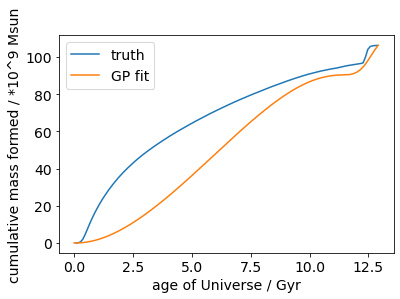

In [575]:
#cumulative mass formed vs age
Mstar_total_lt = np.trapz(lt_sfh, x=lt_ages)
c_lt_sfh = np.zeros(len(lt_ages))
for i,sfh in enumerate(lt_sfh):
    c_lt_sfh[i] = np.trapz(lt_sfh[:i+1],x=lt_ages[:i+1])#/Mstar_total_lt

plt.plot(model_ages, c_model_sfh, label='truth')
plt.plot(lt_ages, c_lt_sfh, label='GP fit')
plt.xlabel('age of Universe / Gyr')
plt.ylabel('cumulative mass formed / *10^9 Msun')
plt.legend()
plt.show()

More bins?

      fun: -6.016697098087555
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-4.56878215e-06,  9.55767757e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 13
      nit: 12
     njev: 13
   status: 0
  success: True
        x: array([-0.80137483, -1.73518999])
      fun: -11.140753323857918
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.90981274e-06,  2.29842208e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 14
      nit: 13
     njev: 14
   status: 0
  success: True
        x: array([-1.07372034, -2.36267171])
      fun: -20.138298375661652
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 3.10274011e-08, -3.87533168e-08])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 16
      nit: 15
     njev: 16
   status: 0
  success: True
        x: array([-1.12779785, -2.30889931])
      fun: -35.5624773423219
 hess_inv: <2x2

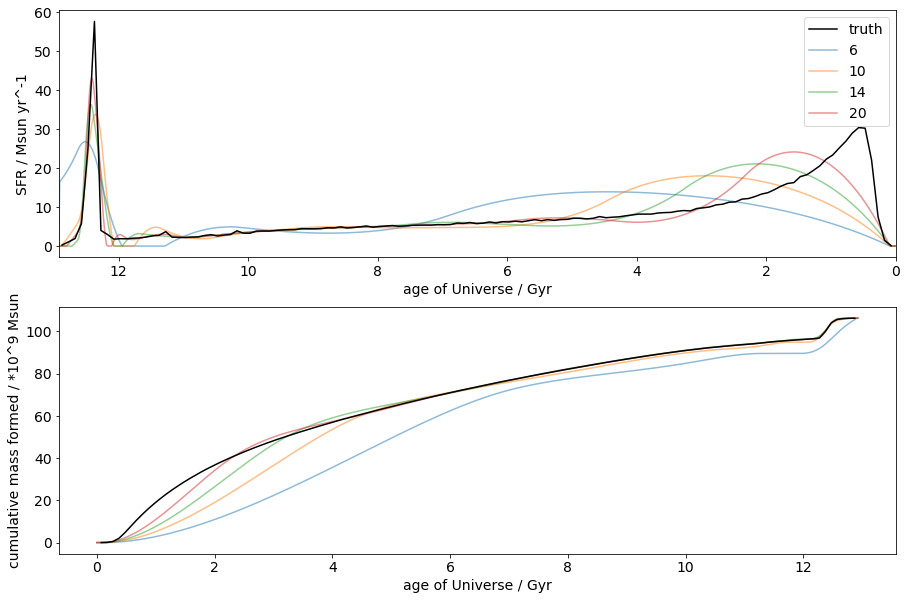

In [558]:
fig, ax = plt.subplots(2,1,figsize=[15,10])
ax[0].plot(model_ages, model_sfh, label='truth', zorder=4, color='k')
ax[1].plot(model_ages, c_model_sfh, label='truth', zorder=4, color='k')
for Nbins in [6,10,14,20]:
    tx,mf = bin_logtime(Nbins)
    lt_ages, lt_sfh = lt_fit(Nbins, tx, mf)
    ax[0].plot(lt_ages, lt_sfh, label=Nbins, alpha=0.5)
    
    c_lt_sfh = np.zeros(len(lt_ages))
    for i,sfh in enumerate(lt_sfh):
        c_lt_sfh[i] = np.trapz(lt_sfh[:i+1],x=lt_ages[:i+1])
    ax[1].plot(lt_ages, c_lt_sfh, label=Nbins, alpha=0.5)
ax[0].set_xlim([age_at_z,0])
ax[0].set_xlabel('age of Universe / Gyr')
ax[0].set_ylabel('SFR / Msun yr^-1')
ax[0].legend()
ax[1].set_xlabel('age of Universe / Gyr')
ax[1].set_ylabel('cumulative mass formed / *10^9 Msun')
plt.show()

Comments:

There seems to be some issue with my binning calculation or cumulative mass formed calculations, where low number of bins' GP fitted cumulative mass formed always seem to be lower than the truth throughout the galaxy's history.
With this method of binning, the big starburst peak is very easily recovered with a relatively few number of bins, but the early SFH shapes are often lost. I have also added varying customizable begin and end times (in lookback times) where the bin boundaries are cut from. This means that by shrinking the end time, the bin boundaries will be more clustered to the recent bit of SFH. This shrinkage seems to help recovering the burst's shape with fewer bins.

# How about mixing the two together?
A second idea Vivienne had was to mix the two binning schemes together to get the best of both worlds. This might mean fitting for (a fewer number of) bin boundaries in both schemes, then using a unified GP-sfh reconstruction function to recreate the SFH.

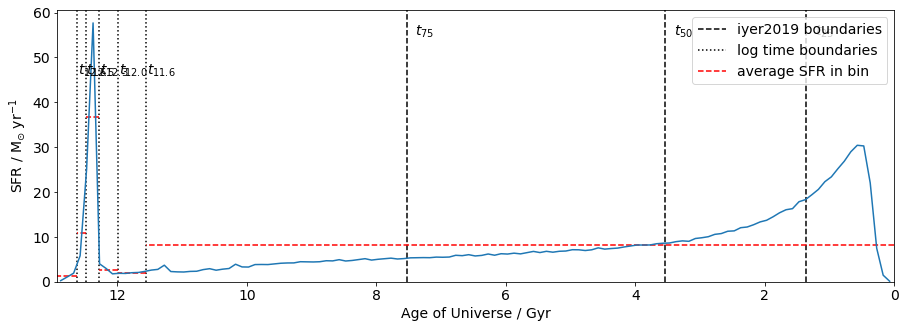

In [586]:
Nbins = [4,6]
tx_iyer = bin_iyer(Nbins[0])
tx_lt, mf_lt = bin_logtime(Nbins[1], end_time=2*10**9)
tx_lt_ = np.array([0,*tx_lt, 1])*age_at_z
mf_lt_ = np.insert(mf_lt, len(mf_lt), 1-np.sum(mf_lt))
durations = abs(tx_lt_[1:] - tx_lt_[:-1])
sfrs = mf_lt_*np.trapz(y=model_sfh, x=model_ages*10**9)/durations/10**9

fig, ax = plt.subplots(figsize=[15,5])
ax.plot(model_ages, model_sfh)
ax.set_xlim([age_at_z,0])
ax.set_xlabel('Age of Universe / Gyr')
ax.set_ylabel(r'SFR / $\rm{M_{\odot}}\; \rm{yr}^{-1}$')
ylims = ax.get_ylim()

ax.vlines(tx_iyer*age_at_z, 0, ylims[1], color='k', ls='--', label='iyer2019 boundaries')
for i,txi in enumerate(tx_iyer):
    ax.annotate('$t_{'+str(int((i+1)*100/Nbins[0]))+'}$', [(txi-0.01)*age_at_z, 0.95*max(model_sfh)])
ax.vlines(tx_lt*age_at_z, 0, ylims[1], color='k', ls=':', label='log time boundaries')
ax.hlines(sfrs, tx_lt_[:-1], tx_lt_[1:], color='r', ls='--', label='average SFR in bin')
for i,txi in enumerate(tx_lt):
    ax.annotate('$t_{'+str(np.round(txi*age_at_z,1))+'}$', [(txi*age_at_z-0.01), 0.8*max(model_sfh)])
    
ax.set_ylim([0,ylims[1]])
ax.legend()
plt.show()

Next, we need to combine the two bin boundary instructions into one for the fit to work

[0.10551834 0.27385026 0.58230328 0.89411146 0.92754519 0.9504224
 0.96607626 0.9767875 ] [0.25       0.25       0.25       0.1465901  0.00825109 0.00757255
 0.07000192 0.01419236]
      fun: -8.655513590583531
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-6.60096927e-06,  4.53817620e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 15
      nit: 14
     njev: 15
   status: 0
  success: True
        x: array([-1.04441359, -2.92939625])


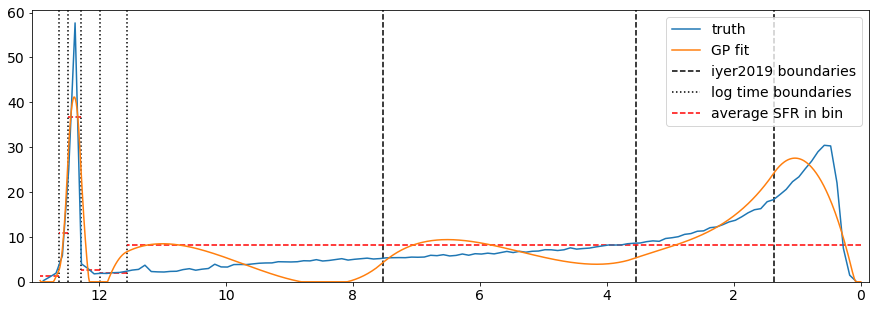

In [587]:
#converting dense_basis info into log time info
c_mf_iyer = np.arange(1,Nbins[0])/Nbins[0]
c_mf_lt = np.cumsum(mf_lt)
c_mf = np.concatenate((c_mf_iyer, c_mf_lt))
tx = np.concatenate((tx_iyer, tx_lt))
sort_ind = np.argsort(tx)
tx = tx[sort_ind]
c_mf = np.insert(c_mf[sort_ind],0,0)
mf = c_mf[1:]-c_mf[:-1]
print(tx, mf)

combine_ages, combine_sfh= lt_fit(np.sum(Nbins)-1, tx, mf)
fig, ax = plt.subplots(figsize=[15,5])
ax.plot(model_ages, model_sfh, label='truth')
ylims = ax.get_ylim()
ax.vlines(tx_iyer*age_at_z, 0, ylims[1], color='k', ls='--', label='iyer2019 boundaries')
ax.vlines(tx_lt*age_at_z, 0, ylims[1], color='k', ls=':', label='log time boundaries')
ax.hlines(sfrs, tx_lt_[:-1], tx_lt_[1:], color='r', ls='--', label='average SFR in bin')
ax.plot(combine_ages, combine_sfh, label='GP fit')
ax.set_xlim([age_at_z*1.01,-age_at_z*0.01])
ax.set_ylim([0,ylims[1]])
ax.legend()
plt.show()

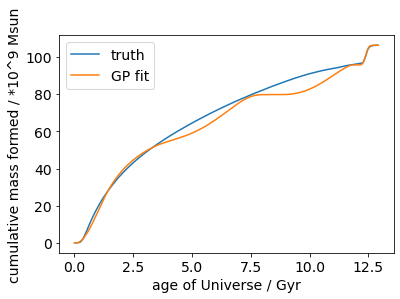

In [588]:
#cumulative mass formed vs age
Mstar_total_combine = np.trapz(combine_sfh, x=combine_ages)
c_combine_sfh = np.zeros(len(combine_ages))
for i,sfh in enumerate(combine_sfh):
    c_combine_sfh[i] = np.trapz(combine_sfh[:i+1],x=combine_ages[:i+1])#/Mstar_total_combine

plt.plot(model_ages, c_model_sfh, label='truth')
plt.plot(combine_ages, c_combine_sfh, label='GP fit')
plt.xlabel('age of Universe / Gyr')
plt.ylabel('cumulative mass formed / *10^9 Msun')
plt.legend()
plt.show()

      fun: -5.227022054149025
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.85520501e-06,  8.14741270e-08])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 12
      nit: 11
     njev: 12
   status: 0
  success: True
        x: array([-0.89039383, -1.30354529])
      fun: -7.985137160818219
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-5.42550971e-06,  1.94556765e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 14
      nit: 13
     njev: 14
   status: 0
  success: True
        x: array([-0.82958708, -1.7551658 ])
      fun: -18.48718416751039
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.52482114e-05, -7.70440429e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 13
      nit: 12
     njev: 13
   status: 0
  success: True
        x: array([-0.99813309, -1.67172167])
      fun: -27.218358958312255
 hess_inv: <2x2 

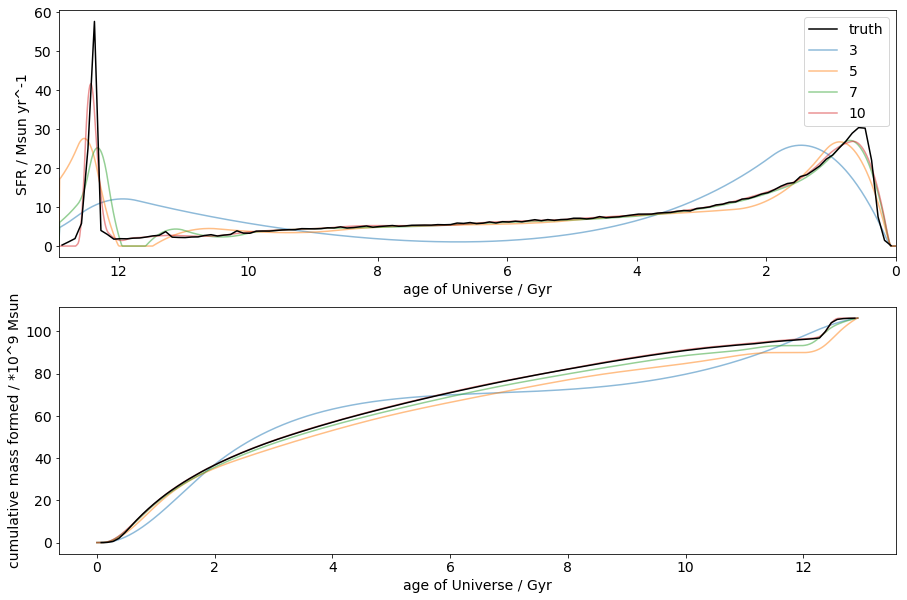

In [566]:
fig, ax = plt.subplots(2,1,figsize=[15,10])
ax[0].plot(model_ages, model_sfh, label='truth', zorder=4, color='k')
ax[1].plot(model_ages, c_model_sfh, label='truth', zorder=4, color='k')
for Nbins in [3,5,7,10]:
    tx_iyer = bin_iyer(Nbins)
    tx_lt, mf_lt = bin_logtime(Nbins, end_time=5*10**9)
    c_mf_iyer = np.arange(1,Nbins)/Nbins
    c_mf_lt = np.cumsum(mf_lt)
    c_mf = np.concatenate((c_mf_iyer, c_mf_lt))
    tx = np.concatenate((tx_iyer, tx_lt))
    sort_ind = np.argsort(tx)
    tx = tx[sort_ind]
    c_mf = np.insert(c_mf[sort_ind],0,0)
    mf = c_mf[1:]-c_mf[:-1]

    combine_ages, combine_sfh= lt_fit(2*Nbins-1, tx, mf)
    ax[0].plot(combine_ages, combine_sfh, label=Nbins, alpha=0.5)
    
    c_combine_sfh = np.zeros(len(combine_ages))
    for i,sfh in enumerate(combine_sfh):
        c_combine_sfh[i] = np.trapz(combine_sfh[:i+1],x=combine_ages[:i+1])
    ax[1].plot(lt_ages, c_combine_sfh, label=Nbins, alpha=0.5)
ax[0].set_xlim([age_at_z,0])
ax[0].set_xlabel('age of Universe / Gyr')
ax[0].set_ylabel('SFR / Msun yr^-1')
ax[0].legend()
ax[1].set_xlabel('age of Universe / Gyr')
ax[1].set_ylabel('cumulative mass formed / *10^9 Msun')
plt.show()

Coments: 

This seems promising. Recreation of both the early SFH behaviours and the shape of the starburst with a relatively sensible number of bins seems to be working, of course given 100% accurate placed bin boundaries (because I am directly fitting the true SFH instead of inferring those boundaries from the spectrum!). Tweaking the begin and end times of the log time binning function seems to be able to compress the number of bins needed in total to get a good recreation as well. This can be thought of telling the uniform-in-log-time bins to specialize in illistrating the shape of the starburst by giving it only the very recent bit of SFH to uniformly divide in log time, which means it requires less bins to capture the burst's SFH shape effectively with these bin boundaries. However, doing this might lose generalisability towards other types of SFHs, or even PSBs with slightly earlier starbursts (e.g. if t_burst is before the set end_time?).

In order for this mixed scheme to work in Bagpipes, the two binning schemes' relevent parameters will probably have to be sampled seperately. Iyer's parameters will be the bin boundaries (tx) under one dirichlet distribution, and the log time binning will be the fractional mass formed in each bin under another dirichlet distribution. Then a function combines the two schemes together and uses a GP to fit for the SFH.

# Experimenting with various begin and end times on combined binning

end time set as None
      fun: -4.957309452423688
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-7.89952079e-07,  6.93125415e-08])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 12
      nit: 11
     njev: 12
   status: 0
  success: True
        x: array([-0.92695391, -1.2668768 ])
      fun: -9.030537650790663
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 3.63435514e-05, -2.12746118e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 12
      nit: 11
     njev: 12
   status: 0
  success: True
        x: array([-0.82817705, -1.3947348 ])
      fun: -16.83146411742711
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.04975486e-07,  2.74118065e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 14
      nit: 13
     njev: 14
   status: 0
  success: True
        x: array([-0.70267155, -1.21345681])
      fun: -28.24502713008

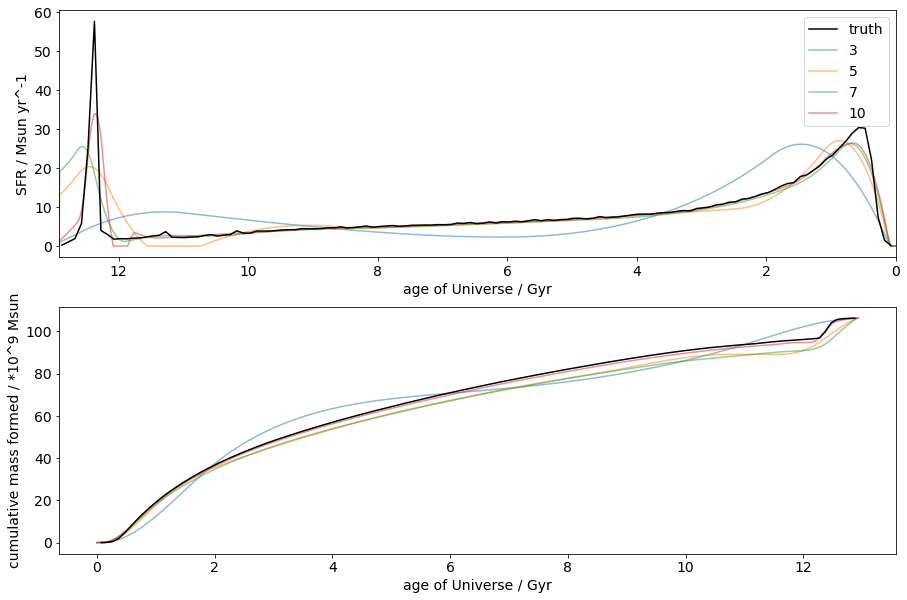

end time set as 5000000000
      fun: -5.227022054149025
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.85520501e-06,  8.14741270e-08])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 12
      nit: 11
     njev: 12
   status: 0
  success: True
        x: array([-0.89039383, -1.30354529])
      fun: -7.985137160818219
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-5.42550971e-06,  1.94556765e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 14
      nit: 13
     njev: 14
   status: 0
  success: True
        x: array([-0.82958708, -1.7551658 ])
      fun: -18.48718416751039
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.52482114e-05, -7.70440429e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 13
      nit: 12
     njev: 13
   status: 0
  success: True
        x: array([-0.99813309, -1.67172167])
      fun: -27.21835

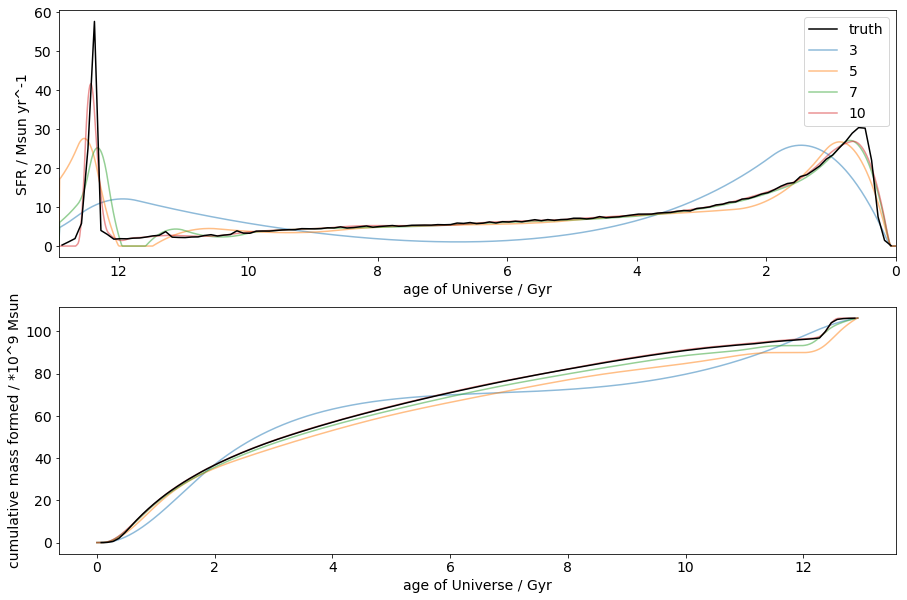

end time set as 3000000000
      fun: -5.288407184230124
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-3.07607528e-06, -3.69247459e-08])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 12
      nit: 11
     njev: 12
   status: 0
  success: True
        x: array([-0.854679 , -1.3574617])
      fun: -11.044692587397183
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.99426404e-07,  4.94816049e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 14
      nit: 13
     njev: 14
   status: 0
  success: True
        x: array([-0.78043939, -1.34129113])
      fun: -13.119349748649409
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 5.46888951e-06, -4.82100495e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 16
      nit: 15
     njev: 16
   status: 0
  success: True
        x: array([-1.1255772 , -2.64606088])
      fun: -30.2014

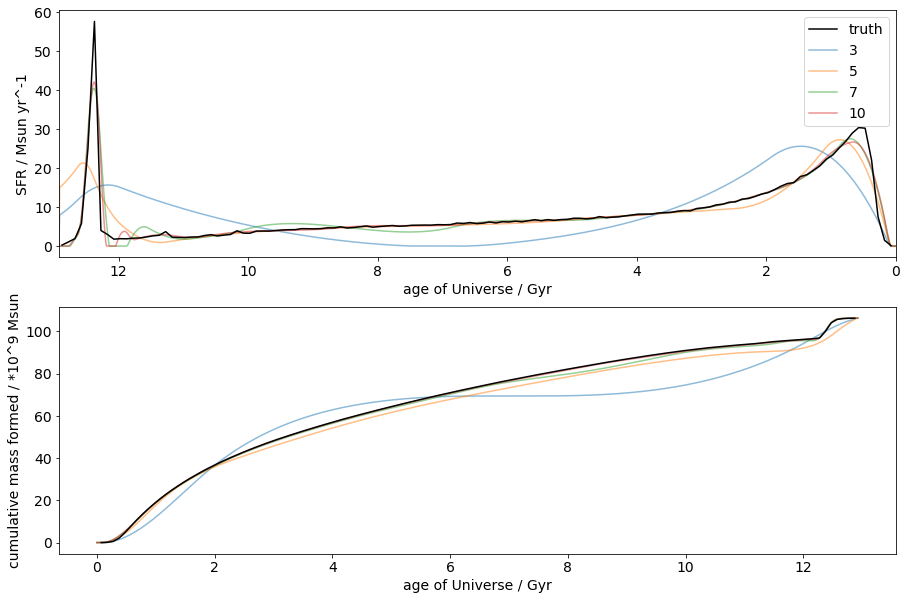

end time set as 2000000000
      fun: -5.211501824349222
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.51736456e-06,  3.97689860e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 12
      nit: 11
     njev: 12
   status: 0
  success: True
        x: array([-0.81882819, -1.45122249])
      fun: -10.666168851402988
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.59059885e-06,  2.13900353e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 13
      nit: 12
     njev: 13
   status: 0
  success: True
        x: array([-0.97886493, -1.88392934])
      fun: -14.412192394689377
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 4.86603233e-06, -4.44554234e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 16
      nit: 15
     njev: 16
   status: 0
  success: True
        x: array([-1.12946381, -2.72585077])
      fun: -32.42

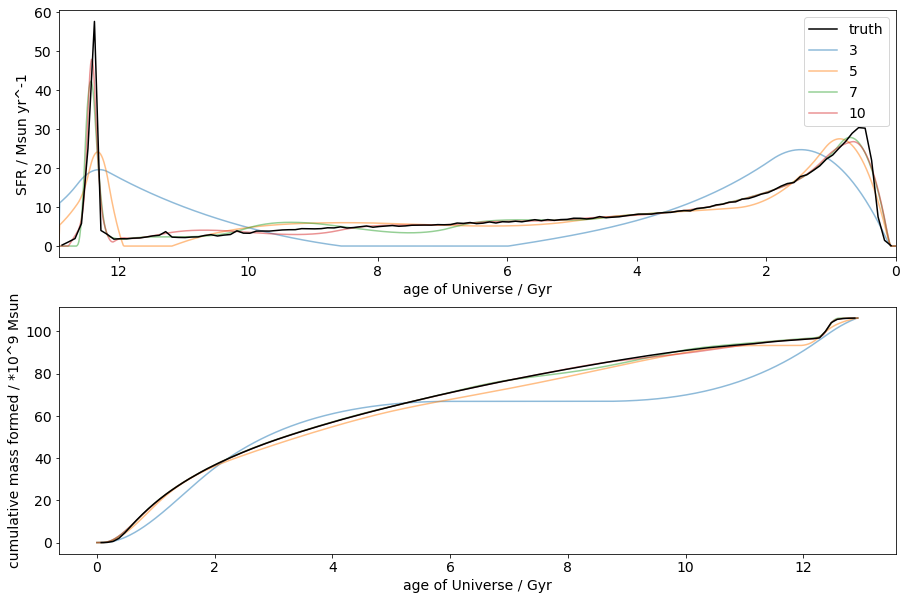

end time set as 1500000000.0
      fun: -5.051408934642319
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-7.46951947e-07,  5.58192994e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 12
      nit: 11
     njev: 12
   status: 0
  success: True
        x: array([-0.7956862 , -1.57070782])
      fun: -8.303364752942151
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 3.99593618e-06, -2.46293652e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 15
      nit: 14
     njev: 15
   status: 0
  success: True
        x: array([-1.04262116, -2.69143221])
      fun: -17.501447865175564
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.23341667e-05,  8.48055049e-06])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 15
      nit: 14
     njev: 15
   status: 0
  success: True
        x: array([-1.11448098, -2.52067216])
      fun: -34.17

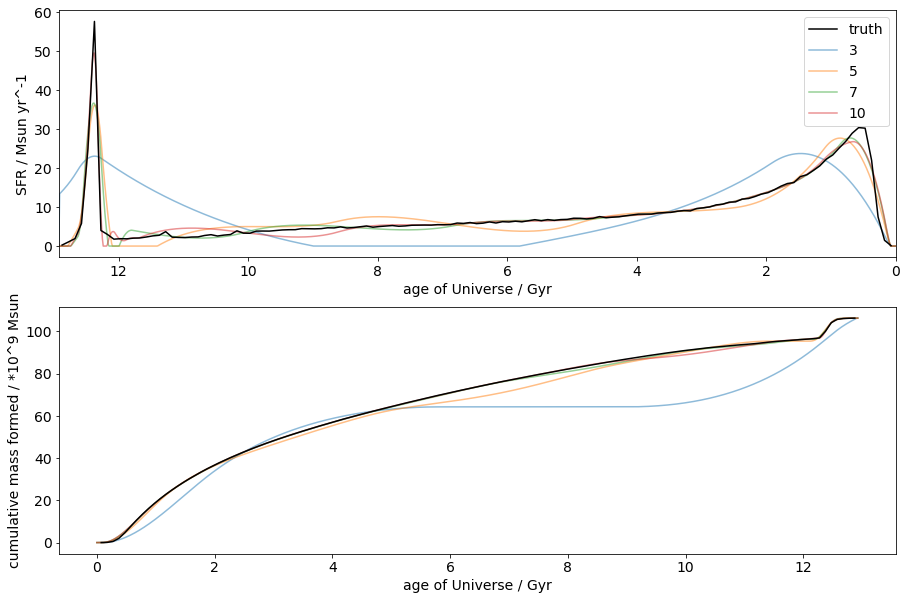

In [589]:
for end_time in [None, 5*10**9, 3*10**9, 2*10**9, 1.5*10**9]:
    print('end time set as', end_time)
    fig, ax = plt.subplots(2,1,figsize=[15,10])
    ax[0].plot(model_ages, model_sfh, label='truth', zorder=4, color='k')
    ax[1].plot(model_ages, c_model_sfh, label='truth', zorder=4, color='k')
    for Nbins in [3,5,7,10]:
        tx_iyer = bin_iyer(Nbins)
        tx_lt, mf_lt = bin_logtime(Nbins, end_time=end_time)
        c_mf_iyer = np.arange(1,Nbins)/Nbins
        c_mf_lt = np.cumsum(mf_lt)
        c_mf = np.concatenate((c_mf_iyer, c_mf_lt))
        tx = np.concatenate((tx_iyer, tx_lt))
        sort_ind = np.argsort(tx)
        tx = tx[sort_ind]
        c_mf = np.insert(c_mf[sort_ind],0,0)
        mf = c_mf[1:]-c_mf[:-1]

        combine_ages, combine_sfh= lt_fit(2*Nbins-1, tx, mf)
        ax[0].plot(combine_ages, combine_sfh, label=Nbins, alpha=0.5)

        c_combine_sfh = np.zeros(len(combine_ages))
        for i,sfh in enumerate(combine_sfh):
            c_combine_sfh[i] = np.trapz(combine_sfh[:i+1],x=combine_ages[:i+1])
        ax[1].plot(lt_ages, c_combine_sfh, label=Nbins, alpha=0.5)
    ax[0].set_xlim([age_at_z,0])
    ax[0].set_xlabel('age of Universe / Gyr')
    ax[0].set_ylabel('SFR / Msun yr^-1')
    ax[0].legend()
    ax[1].set_xlabel('age of Universe / Gyr')
    ax[1].set_ylabel('cumulative mass formed / *10^9 Msun')
    plt.show()